In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# ignore harmless warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_excel(r"C:\Users\sskn0\Downloads\waw (2).xlsx")
dataset.tail()

,Year,1,2,3,4,5,6,7,8,9,10,11,12
13,2010,0.1047,0.1055,0.1087,0.1032,0.0999,0.1090,0.1060,0.1040,0.1059,0.1021,0.1001,0.1082
14,2009,0.1201,0.1253,0.1219,0.1229,0.1189,0.1266,0.1259,0.1249,0.1242,0.1289,0.1289,0.1165
15,2008,0.0889,0.0899,0.0920,0.0940,0.0901,0.0897,0.0920,0.0950,0.0895,0.0870,0.0905,0.0920
16,2007,0.0610,0.0634,0.0650,0.0599,0.0610,0.0639,0.0601,0.0620,0.0589,0.0640,0.0629,0.0620
17,2006,0.0690,0.0659,0.0698,0.0643,0.0678,0.0652,0.0668,0.0689,0.0679,0.0659,0.0610,0.0701


In [3]:
dataset = pd.read_excel(r"C:\Users\sskn0\Downloads\waw (2).xlsx")
dataset.tail()

,Year,1,2,3,4,5,6,7,8,9,10,11,12
13,2019,0.020,0.026,0.029,0.030,0.030,0.032,0.031,0.033,0.040,0.046,0.055,0.074
14,2020,0.076,0.066,0.058,0.072,0.063,0.062,0.067,0.067,0.073,0.076,0.069,0.046
15,2021,0.041,0.050,0.055,0.042,0.063,0.063,0.056,0.053,0.043,0.045,0.049,0.057
16,2022,0.060,0.061,0.070,0.078,0.070,0.070,0.067,0.070,0.074,0.068,0.059,0.057
17,2023,0.065,0.064,0.057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
dataset = dataset.melt(id_vars=['Year'], var_name='Month', value_name='Rate')
dataset.head()

,Year,Month,Rate
0,2006,1,0.0690
1,2007,1,0.0610
2,2008,1,0.0889
3,2009,1,0.1201
4,2010,1,0.1047


In [5]:
from pandas.tseries.offsets import MonthEnd
dataset['Date'] = pd.to_datetime(dataset[['Year', 'Month']].assign(DAY=1)) + MonthEnd(1)
dataset = dataset.sort_values(by=['Date'])
dataset.head()

,Year,Month,Rate,Date
0,2006,1,0.0690,2006-01-31
18,2006,2,0.0659,2006-02-28
36,2006,3,0.0698,2006-03-31
54,2006,4,0.0643,2006-04-30
72,2006,5,0.0678,2006-05-31


In [6]:
df = dataset[['Date', 'Rate']]
df.set_index('Date', inplace=True)
df.dropna(subset=['Rate'], inplace=True)
df.tail()

,Rate
Date,
2022-11-30,0.059
2022-12-31,0.057
2023-01-31,0.065
2023-02-28,0.064
2023-03-31,0.057


In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rate,207.0,0.070323,0.026254,0.02,0.049,0.0659,0.09445,0.1289


<Axes: xlabel='Date'>

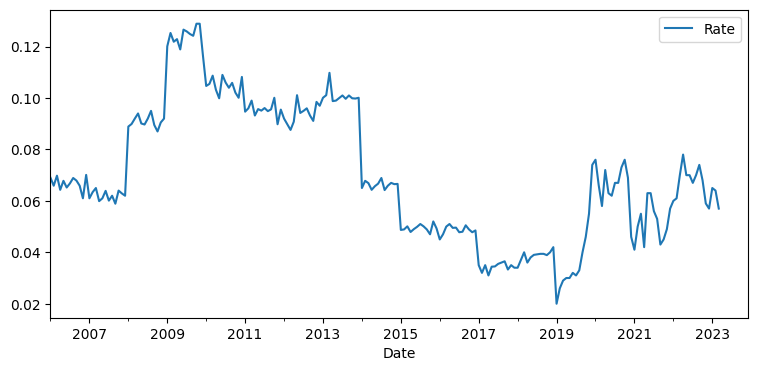

In [8]:
dataset.plot(x='Date', y='Rate', figsize=(9,4))

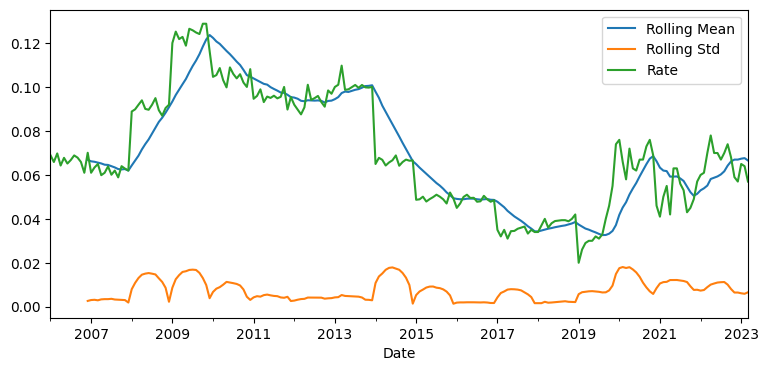

In [9]:
time_series = df['Rate']
time_series.rolling(window=12).mean().plot(label='Rolling Mean')
time_series.rolling(window=12).std().plot(label='Rolling Std')
time_series.plot(figsize=(9,4))
plt.legend()
plt.show()

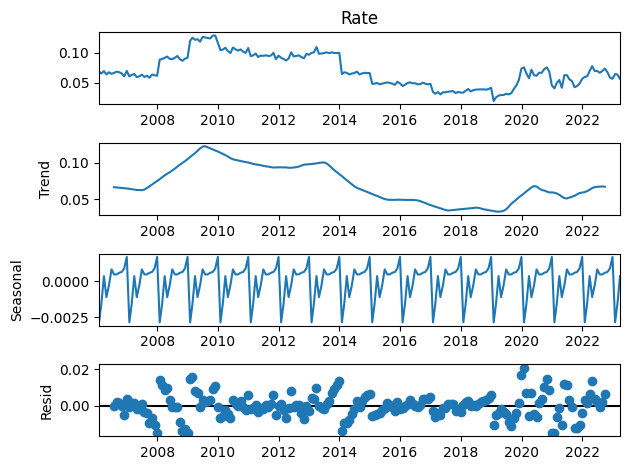

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(time_series)
fig = decomp.plot()

In [11]:
from statsmodels.tsa.stattools import adfuller

# ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('1. ADF: ', result[0])
    print('2. P-value: ', result[1])
    print('3. Num of Lags: ', result[2])
    print('4. Num of Observations: ', result[3])
    print('5. Critial Values:')
    for key, value in result[4].items():
        print('\t', key, ': ', value)
        
    if result[1] <= 0.05:
        print('\nStrong evidence against the null hypothesis (H0), reject the null hypothesis. Data has no unit root and is stationary.')
    else:
        print('\nWeak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.')

# run function
adf_test(df['Rate'])

1. ADF:  -1.790757558644796
2. P-value:  0.38505986762581323
3. Num of Lags:  0
4. Num of Observations:  206
5. Critial Values:
	 1% :  -3.4624988216864776
	 5% :  -2.8756749365852587
	 10% :  -2.5743041549627677

Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.


In [12]:
from pmdarima.arima.utils import ndiffs
print(ndiffs(df['Rate'], test='adf'))
print(ndiffs(df['Rate'], test='kpss'))
print(ndiffs(df['Rate'], test='pp'))

1
1
1


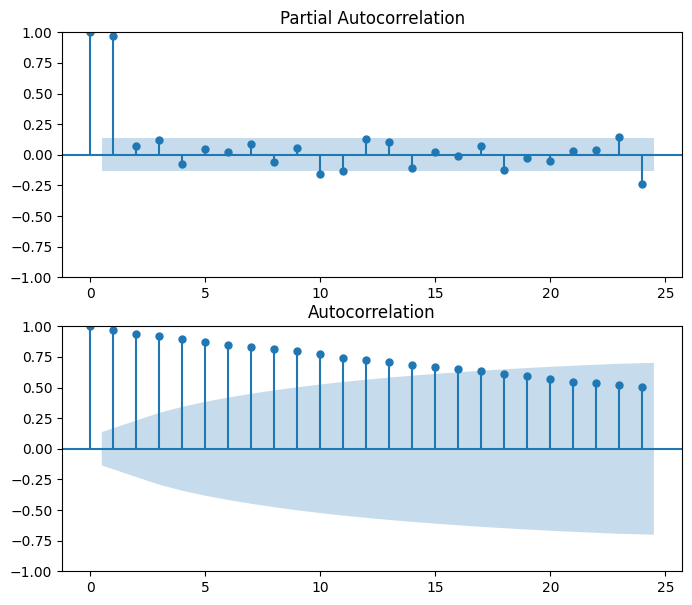

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(8,7))
ax1 = fig.add_subplot(2,1,1)
fig = plot_pacf(df, ax=ax1)
ax2 = fig.add_subplot(2,1,2)
fig = plot_acf(df, ax=ax2)
plt.show()

In [14]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(df['Rate'], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1473.478, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1476.391, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1475.250, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1475.422, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1478.375, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1473.569, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.337 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  207
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 740.187
Date:                Sun, 16 Apr 2023   AIC                          -1478.375
Time:                        01:14:32   BIC                          -1475.047
Sample:                    01-31-2006   HQIC                         -1477.029
                         - 03-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.432e-05   2.08e-06     21.290      0.000    4.02e-05    4.84e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.87   Jarque-Bera (JB):               399.61
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -0.34
Prob(H) (two-sided):                  0.32   Kurtosis:                         9.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
from statsmodels.tsa.arima.model import ARIMA

# fitting the model
model = ARIMA(df['Rate'], order=(1,1,1), freq='M')
model_fit = model.fit()
model_fit.summary()

C:\Users\sskn0\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Rate   No. Observations:                  207
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 740.776
Date:                Sun, 16 Apr 2023   AIC                          -1475.552
Time:                        01:14:51   BIC                          -1465.568
Sample:                    01-31-2006   HQIC                         -1471.514
                         - 03-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0589      1.348      0.044      0.965      -2.582       2.700
ma.L1         -0.1221      1.338     -0.091      0.927      -2.744       2.500
sigma2      4.406e-05   2.06e-06     21.349      0.000       4e-05    4.81e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               411.18
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                            -0.34
Prob(H) (two-sided):                  0.30   Kurtosis:                         9.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
from statsmodels.tsa.arima.model import ARIMA

# fitting the model
model = ARIMA(df['Rate'], order=(0,1,0), freq='M')
model_fit = model.fit()
model_fit.summary()

C:\Users\sskn0\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Rate   No. Observations:                  207
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 740.187
Date:                Sun, 16 Apr 2023   AIC                          -1478.375
Time:                        01:15:15   BIC                          -1475.047
Sample:                    01-31-2006   HQIC                         -1477.029
                         - 03-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.432e-05   2.08e-06     21.290      0.000    4.02e-05    4.84e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.87   Jarque-Bera (JB):               399.61
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -0.34
Prob(H) (two-sided):                  0.32   Kurtosis:                         9.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
from statsmodels.tsa.arima.model import ARIMA

# fitting the model
model = ARIMA(df['Rate'], order=(1,1,1), freq='M')
model_fit = model.fit()
model_fit.summary()

C:\Users\sskn0\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Rate   No. Observations:                  207
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 740.776
Date:                Sun, 16 Apr 2023   AIC                          -1475.552
Time:                        01:15:28   BIC                          -1465.568
Sample:                    01-31-2006   HQIC                         -1471.514
                         - 03-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0589      1.348      0.044      0.965      -2.582       2.700
ma.L1         -0.1221      1.338     -0.091      0.927      -2.744       2.500
sigma2      4.406e-05   2.06e-06     21.349      0.000       4e-05    4.81e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               411.18
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                            -0.34
Prob(H) (two-sided):                  0.30   Kurtosis:                         9.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
pred = model_fit.predict(start=0, end=len(df) - 1, typ='levels', dynamic=False)

In [19]:
pred.tail()

2022-11-30    0.068346
2022-12-31    0.059611
2023-01-31    0.057201
2023-02-28    0.064519
2023-03-31    0.064004
Freq: M, Name: predicted_mean, dtype: float64

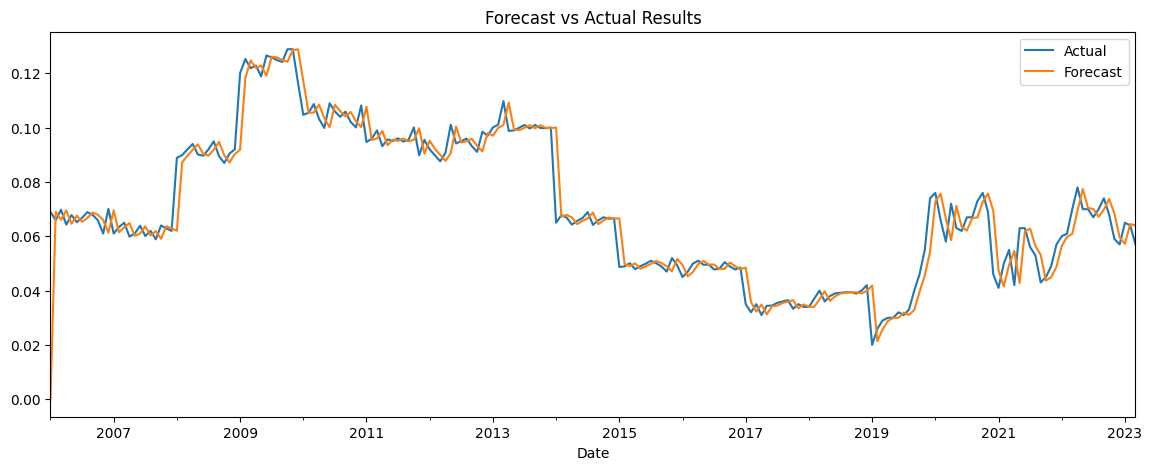

In [20]:
df['Rate'].plot(legend=True, label='Actual', figsize=(14,5))
pred.plot(legend=True, label='Forecast')
plt.title('Forecast vs Actual Results')
plt.show()

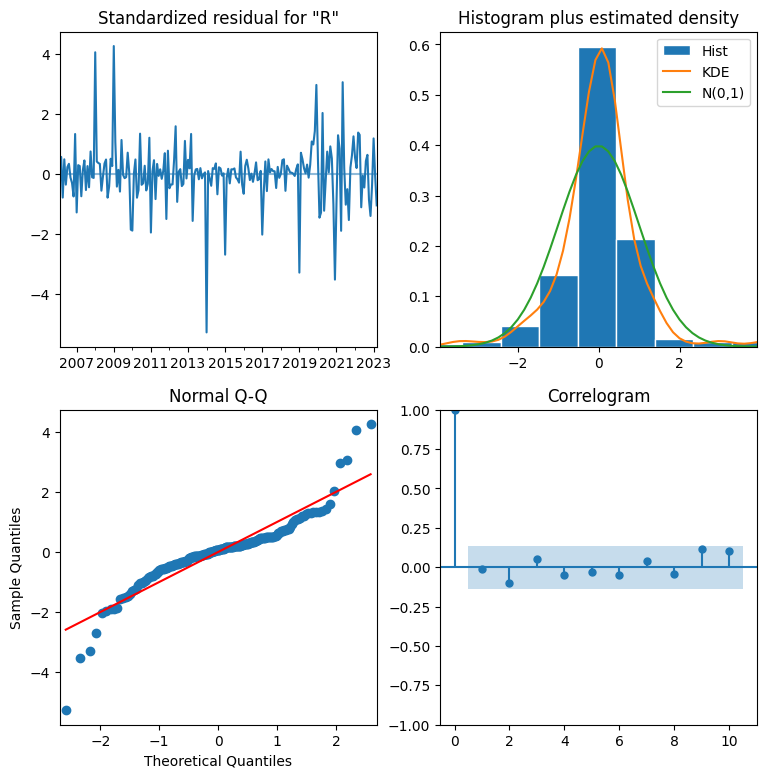

In [21]:
model_fit.plot_diagnostics(figsize=(9,9))
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(pred, df['Rate'], squared=False)
rmse

0.008176190658327821

In [23]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(pred, df['Rate'])
mae

0.004503295116569887

In [24]:
mape = np.mean(np.abs(df['Rate'] - pred) / df['Rate']) * 100
mape

7.344478835721407

In [25]:
forecast = model_fit.predict(start=0, end=len(df) + 5, typ='levels', dynamic=False)

In [26]:
forecast.tail(5)

2023-05-31    0.057469
2023-06-30    0.057470
2023-07-31    0.057471
2023-08-31    0.057471
2023-09-30    0.057471
Freq: M, Name: predicted_mean, dtype: float64

In [27]:
forecast = model_fit.predict(start=0, end=len(df) + 5, typ='levels', dynamic=False)

In [28]:
forecast = model_fit.predict(start=0, end=len(df), typ='levels', dynamic=False)

In [29]:
forecast.tail(5)

2022-12-31    0.059611
2023-01-31    0.057201
2023-02-28    0.064519
2023-03-31    0.064004
2023-04-30    0.057443
Freq: M, Name: predicted_mean, dtype: float64

In [31]:
forecast = model_fit.predict(start=0, end=len(df) + 5, typ='levels', dynamic=False)

In [32]:
forecast.tail(5)

2023-05-31    0.057469
2023-06-30    0.057470
2023-07-31    0.057471
2023-08-31    0.057471
2023-09-30    0.057471
Freq: M, Name: predicted_mean, dtype: float64

In [33]:
print(forecast)

2006-01-31    0.000000
2006-02-28    0.069000
2006-03-31    0.066094
2006-04-30    0.069577
2006-05-31    0.064620
                ...   
2023-05-31    0.057469
2023-06-30    0.057470
2023-07-31    0.057471
2023-08-31    0.057471
2023-09-30    0.057471
Freq: M, Name: predicted_mean, Length: 213, dtype: float64


In [34]:
dataset = pd.read_excel(r"C:\Users\sskn0\Downloads\cpi.xlsx")
dataset.tail()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual
6,2017,130.3,130.6,130.9,131.1,131.4,132.0,134.2,135.4,135.2,136.1,137.6,137.2,133.5
7,2016,126.3,126.0,126.0,127.3,128.6,130.1,131.1,131.1,130.9,131.4,131.2,130.4,129.2
8,2015,119.5,119.7,120.2,120.7,121.6,123.0,123.6,124.8,125.4,126.1,126.6,126.1,123.1
9,2014,113.6,113.6,114.2,115.1,115.8,116.7,119.2,120.3,120.1,120.1,120.1,119.4,117.3
10,2013,104.6,105.3,105.5,106.1,106.9,109.3,111.0,112.4,113.7,114.8,116.3,114.5,110.0


In [35]:
dataset = dataset.melt(id_vars=['Year'], var_name='Month', value_name='Rate')
dataset.head()

,Year,Month,Rate
0,2023,Jan,176.5
1,2022,Jan,165.7
2,2021,Jan,156.3
3,2020,Jan,150.2
4,2019,Jan,139.6


In [36]:
from pandas.tseries.offsets import MonthEnd
dataset['Date'] = pd.to_datetime(dataset[['Year', 'Month']].assign(DAY=1)) + MonthEnd(1)
dataset = dataset.sort_values(by=['Date'])
dataset.head()

ValueError: Unable to parse string "Jan" at position 0

In [37]:
dataset = pd.read_excel(r"C:\Users\sskn0\Downloads\cpi.xlsx")
dataset.tail()

,Year,1,2,3,4,5,6,7,8,9,10,11,12
6,2017,130.3,130.6,130.9,131.1,131.4,132.0,134.2,135.4,135.2,136.1,137.6,137.2
7,2016,126.3,126.0,126.0,127.3,128.6,130.1,131.1,131.1,130.9,131.4,131.2,130.4
8,2015,119.5,119.7,120.2,120.7,121.6,123.0,123.6,124.8,125.4,126.1,126.6,126.1
9,2014,113.6,113.6,114.2,115.1,115.8,116.7,119.2,120.3,120.1,120.1,120.1,119.4
10,2013,104.6,105.3,105.5,106.1,106.9,109.3,111.0,112.4,113.7,114.8,116.3,114.5


In [38]:
dataset = dataset.melt(id_vars=['Year'], var_name='Month', value_name='Rate')
dataset.head()

,Year,Month,Rate
0,2023,1,176.5
1,2022,1,165.7
2,2021,1,156.3
3,2020,1,150.2
4,2019,1,139.6


In [39]:
from pandas.tseries.offsets import MonthEnd
dataset['Date'] = pd.to_datetime(dataset[['Year', 'Month']].assign(DAY=1)) + MonthEnd(1)
dataset = dataset.sort_values(by=['Date'])
dataset.head()

,Year,Month,Rate,Date
10,2013,1,104.6,2013-01-31
21,2013,2,105.3,2013-02-28
32,2013,3,105.5,2013-03-31
43,2013,4,106.1,2013-04-30
54,2013,5,106.9,2013-05-31


In [40]:
df = dataset[['Date', 'Rate']]
df.set_index('Date', inplace=True)
df.dropna(subset=['Rate'], inplace=True)
df.tail()

,Rate
Date,
2022-10-31,176.7
2022-11-30,176.5
2022-12-31,175.7
2023-01-31,176.5
2023-02-28,176.8


In [41]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rate,122.0,138.914754,19.541859,104.6,123.9,137.0,154.5,176.8


<Axes: xlabel='Date'>

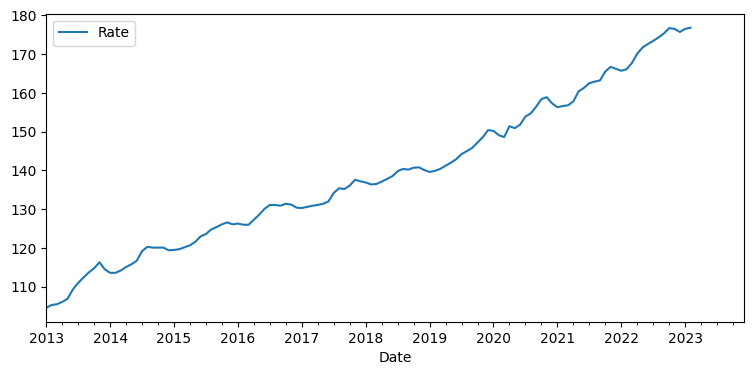

In [42]:
dataset.plot(x='Date', y='Rate', figsize=(9,4))

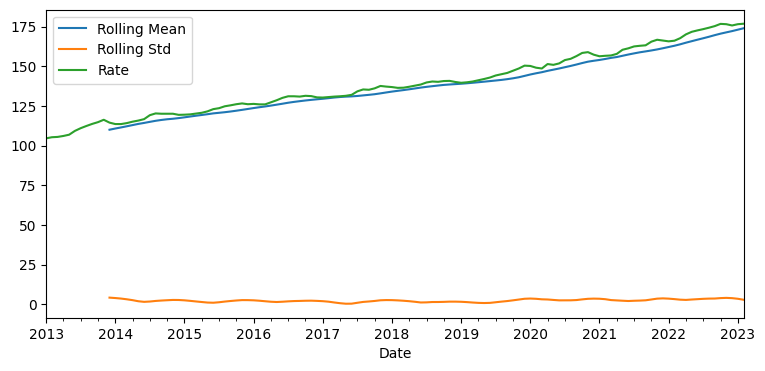

In [43]:
time_series = df['Rate']
time_series.rolling(window=12).mean().plot(label='Rolling Mean')
time_series.rolling(window=12).std().plot(label='Rolling Std')
time_series.plot(figsize=(9,4))
plt.legend()
plt.show()

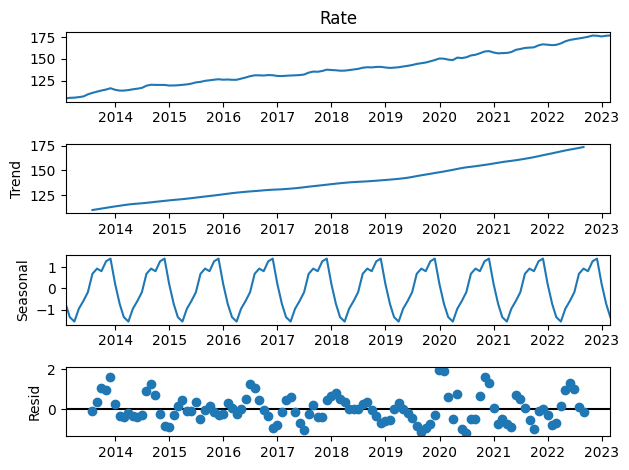

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(time_series)
fig = decomp.plot()

In [45]:
from statsmodels.tsa.stattools import adfuller

# ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('1. ADF: ', result[0])
    print('2. P-value: ', result[1])
    print('3. Num of Lags: ', result[2])
    print('4. Num of Observations: ', result[3])
    print('5. Critial Values:')
    for key, value in result[4].items():
        print('\t', key, ': ', value)
        
    if result[1] <= 0.05:
        print('\nStrong evidence against the null hypothesis (H0), reject the null hypothesis. Data has no unit root and is stationary.')
    else:
        print('\nWeak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.')

# run function
adf_test(df['Rate'])

1. ADF:  1.9166389532481996
2. P-value:  0.9985543235953388
3. Num of Lags:  7
4. Num of Observations:  114
5. Critial Values:
	 1% :  -3.489057523907491
	 5% :  -2.887246327182993
	 10% :  -2.5804808802708528

Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.


In [46]:
from pmdarima.arima.utils import ndiffs
print(ndiffs(df['Rate'], test='adf'))
print(ndiffs(df['Rate'], test='kpss'))
print(ndiffs(df['Rate'], test='pp'))

1
1
1


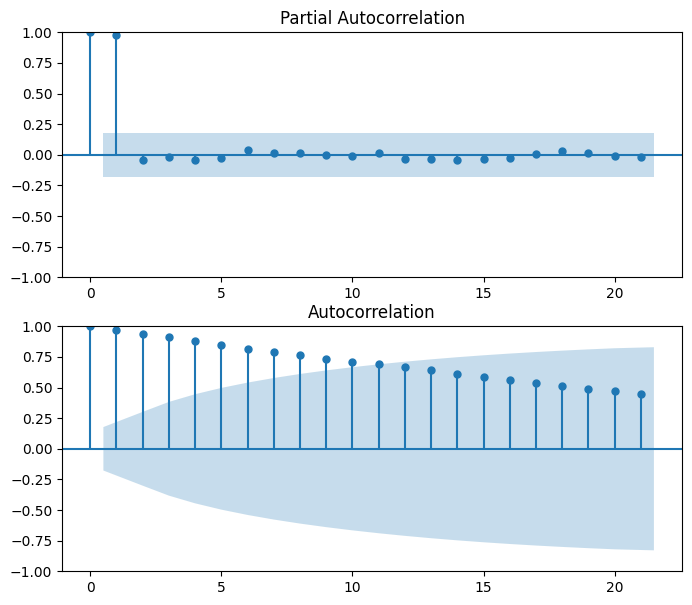

In [47]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(8,7))
ax1 = fig.add_subplot(2,1,1)
fig = plot_pacf(df, ax=ax1)
ax2 = fig.add_subplot(2,1,2)
fig = plot_acf(df, ax=ax2)
plt.show()

In [48]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(df['Rate'], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=314.122, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=298.322, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=292.951, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=358.631, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=294.762, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=294.779, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=317.213, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.842 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  122
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -143.475
Date:                Sun, 16 Apr 2023   AIC                            292.951
Time:                        07:15:03   BIC                            301.338
Sample:                    01-31-2013   HQIC                           296.357
                         - 02-28-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5957      0.107      5.549      0.000       0.385       0.806
ma.L1          0.4780      0.067      7.121      0.000       0.346       0.610
sigma2         0.6259      0.064      9.800      0.000       0.501       0.751
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                11.41
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.83   Skew:                            -0.06
Prob(H) (two-sided):                  0.06   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
from statsmodels.tsa.arima.model import ARIMA

# fitting the model
model = ARIMA(df['Rate'], order=(1,1,1), freq='M')
model_fit = model.fit()
model_fit.summary()

C:\Users\sskn0\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Rate   No. Observations:                  122
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -154.416
Date:                Sun, 16 Apr 2023   AIC                            314.833
Time:                        07:15:31   BIC                            323.220
Sample:                    01-31-2013   HQIC                           318.239
                         - 02-28-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4450      0.141      3.167      0.002       0.170       0.720
ma.L1          0.1768      0.137      1.291      0.197      -0.092       0.445
sigma2         0.7491      0.078      9.651      0.000       0.597       0.901
===================================================================================
Ljung-Box (L1) (Q):                   2.17   Jarque-Bera (JB):                19.83
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                            -0.20
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
from statsmodels.tsa.arima.model import ARIMA

# fitting the model
model = ARIMA(df['Rate'], order=(0,1,1), freq='M')
model_fit = model.fit()
model_fit.summary()

C:\Users\sskn0\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Rate   No. Observations:                  122
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -156.606
Date:                Sun, 16 Apr 2023   AIC                            317.213
Time:                        07:16:02   BIC                            322.804
Sample:                    01-31-2013   HQIC                           319.484
                         - 02-28-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5785      0.059      9.805      0.000       0.463       0.694
sigma2         0.7767      0.084      9.264      0.000       0.612       0.941
===================================================================================
Ljung-Box (L1) (Q):                   1.71   Jarque-Bera (JB):                17.34
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               1.73   Skew:                            -0.11
Prob(H) (two-sided):                  0.09   Kurtosis:                         4.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
pred = model_fit.predict(start=0, end=len(df) - 1, typ='levels', dynamic=False)

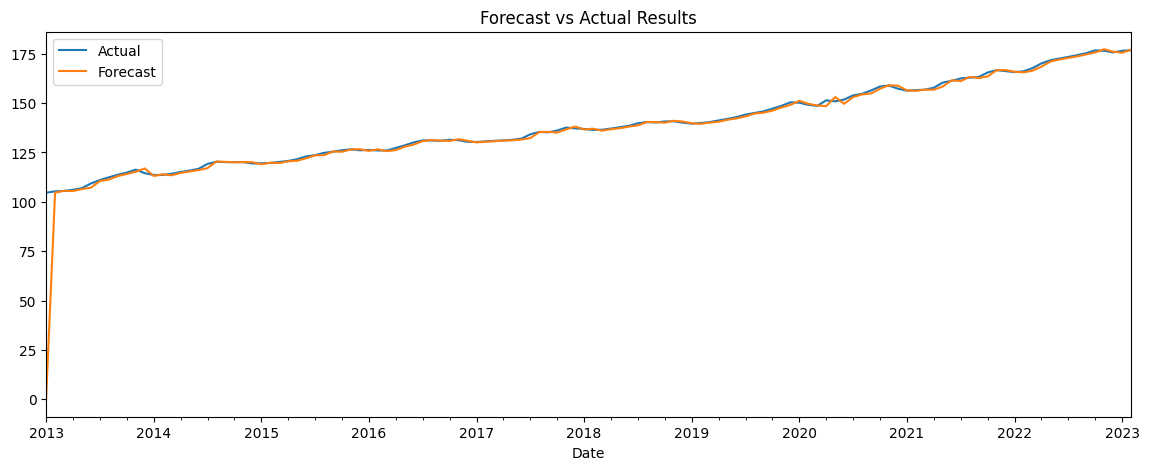

In [52]:
df['Rate'].plot(legend=True, label='Actual', figsize=(14,5))
pred.plot(legend=True, label='Forecast')
plt.title('Forecast vs Actual Results')
plt.show()

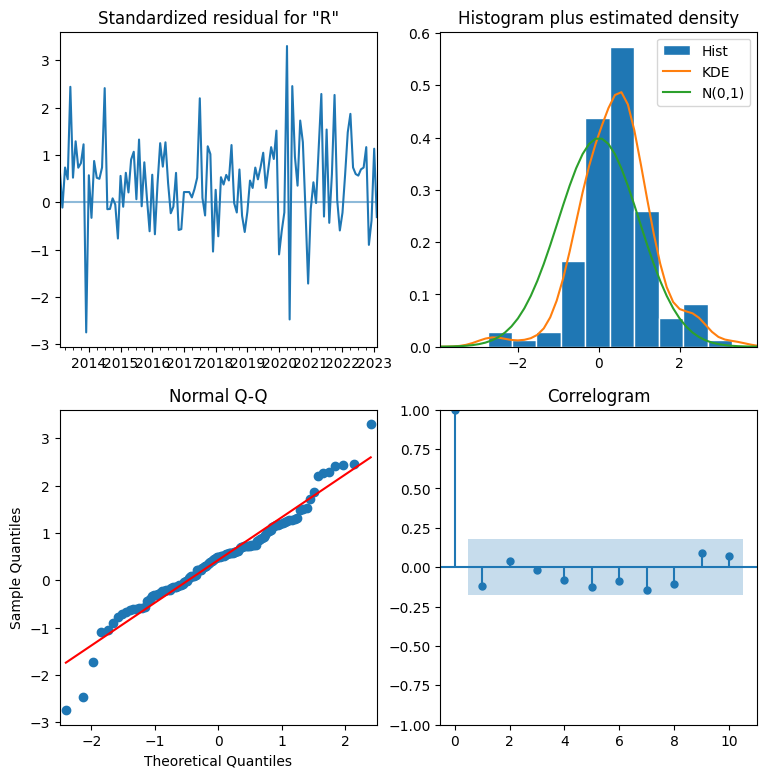

In [54]:
model_fit.plot_diagnostics(figsize=(9,9))
plt.show()

In [55]:
forecast = model_fit.predict(start=0, end=len(df) + 5, typ='levels', dynamic=False)

In [56]:
forecast.head(5)

2013-01-31      0.000000
2013-02-28    104.600047
2013-03-31    105.603393
2013-04-30    105.444817
2013-05-31    106.469459
Freq: M, Name: predicted_mean, dtype: float64

In [57]:
forecast.tail(5)

2023-04-30    176.639846
2023-05-31    176.639846
2023-06-30    176.639846
2023-07-31    176.639846
2023-08-31    176.639846
Freq: M, Name: predicted_mean, dtype: float64

In [65]:
forecast = model_fit.predict(start=0, end=len(df)+1 , typ='levels', dynamic=False)

In [66]:
forecast.tail(5)

2022-12-31    176.040701
2023-01-31    175.502900
2023-02-28    177.076837
2023-03-31    176.639846
2023-04-30    176.639846
Freq: M, Name: predicted_mean, dtype: float64

In [67]:
print(forecast)

2013-01-31      0.000000
2013-02-28    104.600047
2013-03-31    105.603393
2013-04-30    105.444817
2013-05-31    106.469459
                 ...    
2022-12-31    176.040701
2023-01-31    175.502900
2023-02-28    177.076837
2023-03-31    176.639846
2023-04-30    176.639846
Freq: M, Name: predicted_mean, Length: 124, dtype: float64
